In [56]:
# Add MOSQITO to the Python path
import sys
sys.path.append('..')

# Import numpy
import numpy as np
# Import plot function
import matplotlib.pyplot as plt
# Import mosqito functions
#from mosqito.utils import load
from mosqito.sq_metrics import loudness_zwtv, sharpness_din_tv, roughness_dw, pr_ecma_tv, tnr_ecma_tv
from scipy.io import wavfile
from scipy.signal import resample

# Import MOSQITO color sheme [Optional]
from mosqito import COLORS

# To get inline plots (specific to Jupyter notebook)
#%matplotlib notebook

In [53]:
def load(file, wav_calib=None, mat_signal="", mat_fs="", ch=None):
    """Extract the signal and its time axis from .wav or .uff file,
    resample the signal to 48 kHz, and affects its sampling frequency
    and time signal values.

    Parameters
    ----------
    file : string
        string path to the signal file
    wav_calib : float, optional
        Wav file calibration factor [Pa/FS]. Level of the signal in Pa_peak
        corresponding to the full scale of the .wav file. If None, a
        calibration factor of 1 is considered. Default to None.
    mat_signal : string
        in case of a .mat file, name of the signal variable
    mat_fs : string
        in case of a .mat file, name of the sampling frequency variable

    Outputs
    -------
    signal : numpy.array
        time signal values
    fs : integer
        sampling frequency
    """

    # load the .wav file content
    if file[-3:] == "wav" or file[-3:] == "WAV":
        fs, signal = wavfile.read(file)

        # manage multichannel files
        if signal.ndim > 1:
            signal = signal[:, ch] # signal[:, 0] for first channel, signal[:, 1] for second ch

        # calibration factor for the signal to be in Pa
        if wav_calib is None:
            wav_calib = 1
            print("[Info] A calibration of 1 Pa/FS is considered")
        if isinstance(signal[0], np.int16):
            signal = wav_calib * signal / (2**15 - 1)
        elif isinstance(signal[0], np.int32):
            signal = wav_calib * signal / (2**31 - 1)
        elif isinstance(signal[0], np.float):
            signal = wav_calib * signal

    else:
        raise ValueError("""ERROR: only .wav .mat or .uff files are supported""")

    # resample to 48kHz to allow calculation
    if fs != 48000:
        signal = resample(signal, int(48000 * len(signal) / fs))
        fs = 48000

    return signal, fs


# Extract loudness of augmented soundscapes using Mosqito library

We should get the same values that they provide in the responses.csv in ARAUS dataset

#### Load signal

[Info] Multichannel signal loaded. Keeping only second channel
[Info] Signal resampled to 48 kHz to allow calculation.


Text(0, 0.5, 'Acoustic pressure [Pa]')

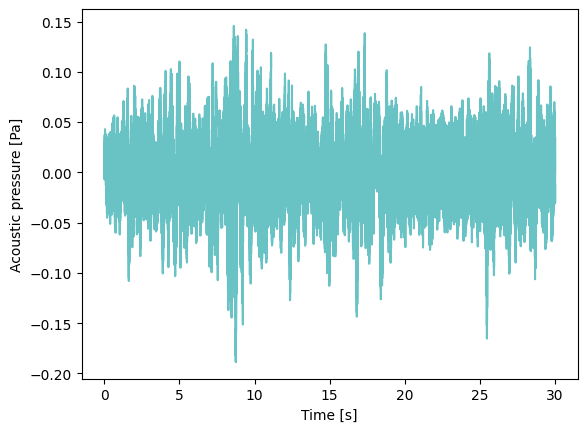

In [24]:
# Define path to the .wav file
# To be replaced by your own path
path = "../data/soundscapes/soundscapes_augmented/fold_1_participant_00001_stimulus_03.wav"
# load signal
#fs, sig = wavfile.read(path)
sig, fs = load(path, wav_calib=2 * 2 **0.5, ch=1) #only get right channel

# plot signal
t = np.linspace(0, (len(sig) - 1) / fs, len(sig))
plt.figure(1)
plt.plot(t, sig, color=COLORS[0])
plt.xlabel('Time [s]')
plt.ylabel('Acoustic pressure [Pa]')

#### Compute loudness

In [53]:
N, N_spec, bark_axis, time_axis = loudness_zwtv(sig, fs, field_type="free")

Text(0, 0.5, 'N_zwtv [sone]')

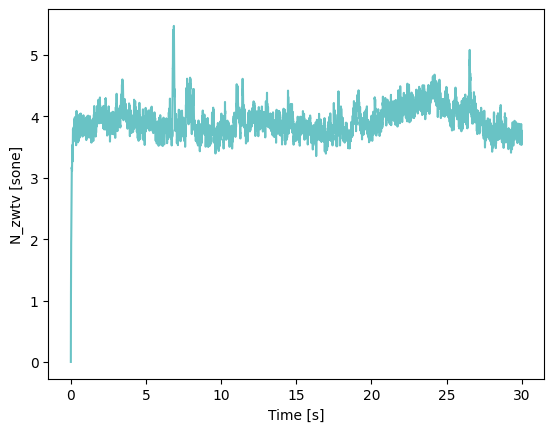

In [47]:
# The loudness of the audio signal is computed as a function of time :
plt.figure(2)
plt.plot(time_axis, N, color=COLORS[0])
plt.xlabel('Time [s]')
plt.ylabel('S_zwtv [sone]')

Text(0.5, 1.0, 't = 0.6 s')

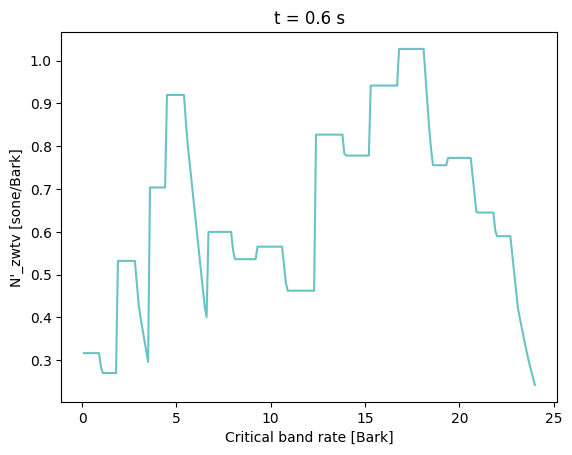

In [9]:
# The specific loudness over time and critical band rate is also computed. It can be plotted over critical band rate 
# for a specific time or over time for a specific critical band rate with the following commands:

i_time = 300
plt.figure(3)
plt.plot(bark_axis, N_spec[:, i_time], color=COLORS[0])
plt.xlabel('Critical band rate [Bark]')
plt.ylabel("N'_zwtv [sone/Bark]")
plt.title("t = {:.1f} s".format(time_axis[i_time]))

#### Calculate N_avg, N_max, percentiles...

In [54]:

N_avg=np.mean(N)

N_max=np.max(N)

N_95=np.percentile(N,95)

print(N_avg, N_max, N_95)

16.972762440998014


# Extract loudness for soundscape (non-augmented)

In [8]:
# Define path to the .wav file
# To be replaced by your own path
path = "../data/R0057_segment_binaural_44100_2.wav"
# load signal
#fs, sig = wavfile.read(path)
sigL, fs = load(path, wav_calib=1/(0.615511), ch=0) #L
sigR, fs = load(path, wav_calib=1/(0.615511), ch=1) #R

[Info] Multichannel signal loaded. Keeping only second channel
[Info] Signal resampled to 48 kHz to allow calculation.
[Info] Multichannel signal loaded. Keeping only second channel
[Info] Signal resampled to 48 kHz to allow calculation.


In [9]:
#L
N_l, N_spec_l, bark_axis_l, time_axis_l = loudness_zwtv(sigL, fs, field_type="free")
N_avg_l=np.mean(N_l)
N_max_l=np.max(N_l)
N_05_l=np.percentile(N_l,95)
print(N_avg_l, N_max_l, N_05_l)

#R
N_r, N_spec_r, bark_axis_r, time_axis_r = loudness_zwtv(sigR, fs, field_type="free")
N_avg_r=np.mean(N_r)
N_max_r=np.max(N_r)
N_05_r=np.percentile(N_r,95)
print(N_avg_r, N_max_r, N_05_r)



7.128639236613928 12.19053711575441 8.031919996155628
8.194431389944441 12.05209906750904 9.10182761355154


In [22]:
error_avg= 16.5-(N_avg_r+N_avg_l)
error_max= 25.3-(N_max_r+N_max_l)
error_05= 21.6-(N_05_r+N_05_l)

print(error_avg, error_max, error_05)

-3.3023214491255217 -3.615825877095549 -3.9011411516097496


In [20]:
#L+R
N_lr, N_spec_lr, bark_axis_lr, time_axis_lr = loudness_zwtv((sigR+sigL), fs, field_type="free")
N_avg_lr=np.mean(N_lr)
N_max_lr=np.max(N_lr)
N_05_lr=np.percentile(N_lr,95)
print(N_avg_lr, N_max_lr, N_05_l)

12.523217346134938 18.39546606385114 11.807209916762078


# Extract sharpness of non-augmented soundscapes using Mosqito library

We should get the same values that they provide in the soundscapes.csv in ARAUS dataset

In [78]:
# Define path to the .wav file
# To be replaced by your own path
path = "../data/soundscapes/R0057_segment_binaural_44100_2.wav"
# load signal
#fs, sig = wavfile.read(path)
sigL, fs = load(path, wav_calib=(1/(0.615511)), ch=0) #L
sigR, fs = load(path, wav_calib=(1/(0.615511)), ch=1) #R

In [79]:
#L
S_l, S_time_l= sharpness_din_tv(sigL, fs, field_type="free", skip=0.01)
S_avg_l=np.mean(S_l)
S_max_l=np.max(S_l)
S_05_l=np.percentile(S_l,95)
print(S_avg_l, S_max_l, S_05_l)

#R
S_r,S_time_r = sharpness_din_tv(sigR, fs, field_type="free", skip=0.01)
S_avg_r=np.mean(S_r)
S_max_r=np.max(S_r)
S_05_r=np.percentile(S_r,95)
print(S_avg_r, S_max_r, S_05_r)

1.6256421548308413 4.736789562136038 1.9119173152744895
1.700710993107283 4.541525664819318 1.989451684718842


ValueError: x and y must have same first dimension, but have shapes (14995,) and (1440000,)

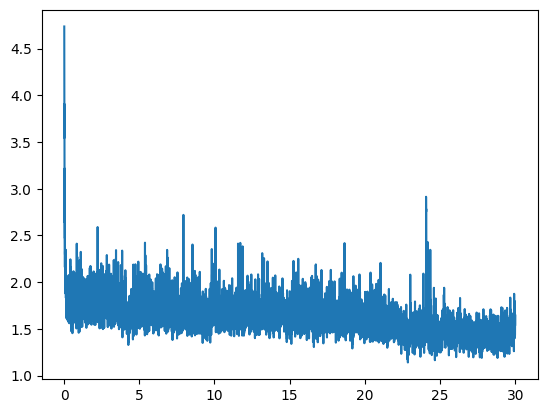

In [81]:
# The sharpness of the audio signal is computed as a function of time :
plt.figure(2)
plt.plot(S_time_l, S_l)
plt.plot(S_time_l,sigL)
plt.xlabel('Time [s]')


In [ ]:
# Error
error_S_avg=1.67-((S_l+S_r)/2)
error_S_max=3.46-((S_max_l+S_max_r)/2)
error_S_05=1.8-((S_05_l+S_05_r)/2)

print(error_avg, error_max, error_S_05)

# Comparing results to detect pattern in errors - loudness

In [5]:
data = [
    [0.759272, 14.8, 22.8, 17.0, 15.8, 15.2, 14.9, 14.7, 14.5, 14.3, 14.2, 14.0, 13.8, 13.6],
    [0.759272, 15.0, 17.6, 16.1, 15.9, 15.6, 15.4, 15.2, 15.0, 14.9, 14.7, 14.5, 14.2, 14.0],
    [1.363361, 18.0, 27.7, 25.1, 22.5, 20.2, 19.3, 18.7, 18.1, 17.6, 16.6, 14.2, 13.2, 12.9],
    [1.363361, 16.3, 38.1, 31.0, 23.2, 19.0, 15.4, 14.6, 13.9, 13.5, 13.2, 12.9, 12.6, 12.4],
    [1.114716, 8.85, 15.5, 11.5, 10.8, 10.3, 9.76, 9.22, 8.72, 7.95, 7.7, 7.48, 7.14, 6.76],
    [1.114716, 7.57, 12.5, 10.4, 9.58, 8.53, 7.76, 7.41, 7.18, 7.04, 6.93, 6.81, 6.67, 6.56],
    [1.041606, 13.1, 16.5, 14.5, 14.2, 13.8, 13.5, 13.3, 13.0, 12.8, 12.6, 12.4, 12.1, 11.9],
    [1.041606, 13.4, 18.2, 15.9, 14.8, 14.1, 13.7, 13.4, 13.1, 12.9, 12.7, 12.5, 12.2, 12.0],
    [1.181325, 6.8, 11.3, 7.52, 7.25, 7.05, 6.93, 6.83, 6.75, 6.68, 6.61, 6.52, 6.41, 6.33],
    [1.181325, 8.05, 12.6, 9.91, 9.19, 8.42, 8.22, 8.06, 7.9, 7.77, 7.62, 7.44, 7.23, 7.07],
    [1.167849, 8.47, 11.8, 9.91, 9.44, 9.04, 8.71, 8.44, 8.28, 8.16, 8.04, 7.9, 7.72, 7.59],
    [1.167849, 12.7, 15.8, 14.2, 14.0, 13.6, 13.4, 13.2, 12.9, 12.7, 12.4, 11.9, 11.1, 10.6],
    [1.117921, 6.9, 11.5, 8.61, 8.18, 7.67, 7.35, 7.06, 6.81, 6.58, 6.32, 6.09, 5.74, 5.5],
    [1.117921, 6.61, 13.3, 8.65, 7.85, 7.27, 6.91, 6.63, 6.4, 6.21, 6.03, 5.85, 5.6, 5.42],
    [1.463234, 9.05, 10.2, 9.58, 9.47, 9.32, 9.21, 9.13, 9.05, 8.97, 8.89, 8.8, 8.67, 8.56],
    [1.463234, 9.02, 11.4, 9.63, 9.46, 9.28, 9.17, 9.08, 9.0, 8.92, 8.83, 8.74, 8.61, 8.51],
    [0.987588, 14.8, 17.0, 15.5, 15.4, 15.1, 15.0, 14.9, 14.8, 14.7, 14.5, 14.4, 14.3, 14.1],
    [0.987588, 14.9, 19.0, 15.7, 15.5, 15.3, 15.2, 15.1, 14.9, 14.8, 14.7, 14.5, 14.4, 14.2],
    [1.028043, 16.6, 28.6, 21.7, 19.9, 18.4, 17.4, 16.6, 16.0, 15.5, 15.0, 14.5, 13.7, 13.3],
    [1.028043, 17.0, 26.6, 20.4, 19.3, 18.3, 17.8, 17.3, 16.8, 16.4, 16.0, 15.4, 14.8, 14.2]
]
ground_truth=np.array(data)

Load signals

In [68]:

# R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
sigL_0001_1, fs = load(path, wav_calib=4.6*ground_truth[0,0]/ground_truth[0,0], ch=0) #L
sigR_0001_1, fs = load(path, wav_calib=4.6*ground_truth[0,0]/ground_truth[0,0], ch=1) #R

# R0001_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_2.wav"
sigL_0001_2, fs = load(path, wav_calib=4.6*ground_truth[1,0]/ground_truth[0,0], ch=0) #L
sigR_0001_2, fs = load(path, wav_calib=4.6*ground_truth[1,0]/ground_truth[0,0], ch=1) #R

# R0002_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0002_segment_binaural_44100_1.wav"
sigL_0002_1, fs = load(path, wav_calib=4.6*ground_truth[2,0]/ground_truth[0,0], ch=0) #L
sigR_0002_1, fs = load(path, wav_calib=4.6*ground_truth[2,0]/ground_truth[0,0], ch=1) #R

# R0002_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0002_segment_binaural_44100_2.wav"
sigL_0002_2, fs = load(path, wav_calib=4.6*ground_truth[3,0]/ground_truth[0,0], ch=0) #L
sigR_0002_2, fs = load(path, wav_calib=4.6*ground_truth[3,0]/ground_truth[0,0], ch=1) #R

# R0003_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0003_segment_binaural_44100_1.wav"
sigL_0003_1, fs = load(path, wav_calib=4.6*ground_truth[4,0]/ground_truth[0,0], ch=0) #L
sigR_0003_1, fs = load(path, wav_calib=4.6*ground_truth[4,0]/ground_truth[0,0], ch=1) #R

# R0003_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0003_segment_binaural_44100_2.wav"
sigL_0003_2, fs = load(path, wav_calib=4.6*ground_truth[5,0]/ground_truth[0,0], ch=0) #L
sigR_0003_2, fs = load(path, wav_calib=4.6*ground_truth[5,0]/ground_truth[0,0], ch=1) #R

# R0004_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0004_segment_binaural_44100_1.wav"
sigL_0004_1, fs = load(path, wav_calib=4.6*ground_truth[6,0]/ground_truth[0,0], ch=0) #L
sigR_0004_1, fs = load(path, wav_calib=4.6*ground_truth[6,0]/ground_truth[0,0], ch=1) #R

# R0004_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0004_segment_binaural_44100_2.wav"
sigL_0004_2, fs = load(path, wav_calib=4.6*ground_truth[7,0]/ground_truth[0,0], ch=0) #L
sigR_0004_2, fs = load(path, wav_calib=4.6*ground_truth[7,0]/ground_truth[0,0], ch=1) #R

# R0005_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0005_segment_binaural_44100_1.wav"
sigL_0005_1, fs = load(path, wav_calib=4.6*ground_truth[8,0]/ground_truth[0,0], ch=0) #L
sigR_0005_1, fs = load(path, wav_calib=4.6*ground_truth[8,0]/ground_truth[0,0], ch=1) #R

# R0005_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0005_segment_binaural_44100_2.wav"
sigL_0005_2, fs = load(path, wav_calib=4.6*ground_truth[9,0]/ground_truth[0,0], ch=0) #L
sigR_0005_2, fs = load(path, wav_calib=4.6*ground_truth[9,0]/ground_truth[0,0], ch=1) #R

# R0006_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0006_segment_binaural_44100_1.wav"
sigL_0006_1, fs = load(path, wav_calib=4.6*ground_truth[10,0]/ground_truth[0,0], ch=0) #L
sigR_0006_1, fs = load(path, wav_calib=4.6*ground_truth[10,0]/ground_truth[0,0], ch=1) #R

# R0006_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0006_segment_binaural_44100_2.wav"
sigL_0006_2, fs = load(path, wav_calib=4.6*ground_truth[11,0]/ground_truth[0,0], ch=0) #L
sigR_0006_2, fs = load(path, wav_calib=4.6*ground_truth[11,0]/ground_truth[0,0], ch=1) #R

# R0007_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0007_segment_binaural_44100_1.wav"
sigL_0007_1, fs = load(path, wav_calib=4.6*ground_truth[12,0]/ground_truth[0,0], ch=0) #L
sigR_0007_1, fs = load(path, wav_calib=4.6*ground_truth[12,0]/ground_truth[0,0], ch=1) #R

# R0007_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0007_segment_binaural_44100_2.wav"
sigL_0007_2, fs = load(path, wav_calib=4.6*ground_truth[13,0]/ground_truth[0,0], ch=0) #L
sigR_0007_2, fs = load(path, wav_calib=4.6*ground_truth[13,0]/ground_truth[0,0], ch=1) #R

# R0008_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0008_segment_binaural_44100_1.wav"
sigL_0008_1, fs = load(path, wav_calib=4.6*ground_truth[14,0]/ground_truth[0,0], ch=0) #L
sigR_0008_1, fs = load(path, wav_calib=4.6*ground_truth[14,0]/ground_truth[0,0], ch=1) #R

# R0008_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0008_segment_binaural_44100_2.wav"
sigL_0008_2, fs = load(path, wav_calib=4.6*ground_truth[15,0]/ground_truth[0,0], ch=0) #L
sigR_0008_2, fs = load(path, wav_calib=4.6*ground_truth[15,0]/ground_truth[0,0], ch=1) #R

# R0009_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0009_segment_binaural_44100_1.wav"
sigL_0009_1, fs = load(path, wav_calib=4.6*ground_truth[16,0]/ground_truth[0,0], ch=0) #L
sigR_0009_1, fs = load(path, wav_calib=4.6*ground_truth[16,0]/ground_truth[0,0], ch=1) #R

# R0009_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0009_segment_binaural_44100_2.wav"
sigL_0009_2, fs = load(path, wav_calib=4.6*ground_truth[17,0]/ground_truth[0,0], ch=0) #L
sigR_0009_2, fs = load(path, wav_calib=4.6*ground_truth[17,0]/ground_truth[0,0], ch=1) #R

# R00010_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0010_segment_binaural_44100_1.wav"
sigL_0010_1, fs = load(path, wav_calib=4.6*ground_truth[18,0]/ground_truth[0,0], ch=0) #L
sigR_0010_1, fs = load(path, wav_calib=4.6*ground_truth[18,0]/ground_truth[0,0], ch=1) #R

# R0010_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0010_segment_binaural_44100_2.wav"
sigL_0010_2, fs = load(path, wav_calib=4.6*ground_truth[19,0]/ground_truth[0,0], ch=0) #L
sigR_0010_2, fs = load(path, wav_calib=4.6*ground_truth[19,0]/ground_truth[0,0], ch=1) #R

Calculate loudness

In [69]:
# R0001_segment_binaural_44100_1.wav
#L
N_l_0001_1, N_spec_l_0001_1, bark_axis_l_0001_1, time_axis_l_0001_1 = loudness_zwtv(sigL_0001_1, fs, field_type="free")
N_avg_l_0001_1=np.mean(N_l_0001_1)
N_max_l_0001_1=np.max(N_l_0001_1)
N_05_l_0001_1=np.percentile(N_l_0001_1,95)
#R
N_r_0001_1, N_spec_r_0001_1, bark_axis_r_0001_1, time_axis_r_0001_1 = loudness_zwtv(sigR_0001_1, fs, field_type="free")
N_avg_r_0001_1=np.mean(N_r_0001_1)
N_max_r_0001_1=np.max(N_r_0001_1)
N_05_r_0001_1=np.percentile(N_r_0001_1,95)

# R0001_segment_binaural_44100_2.wav
#L
N_l_0001_2, N_spec_l_0001_2, bark_axis_l_0001_2, time_axis_l_0001_2 = loudness_zwtv(sigL_0001_2, fs, field_type="free")
N_avg_l_0001_2=np.mean(N_l_0001_2)
N_max_l_0001_2=np.max(N_l_0001_2)
N_05_l_0001_2=np.percentile(N_l_0001_2,95)
#R
N_r_0001_2, N_spec_r_0001_2, bark_axis_r_0001_2, time_axis_r_0001_2 = loudness_zwtv(sigR_0001_2, fs, field_type="free")
N_avg_r_0001_2=np.mean(N_r_0001_2)
N_max_r_0001_2=np.max(N_r_0001_2)
N_05_r_0001_2=np.percentile(N_r_0001_2,95)

# R0002_segment_binaural_44100_1.wav
#L
N_l_0002_1, N_spec_l_0002_1, bark_axis_l_0002_1, time_axis_l_0002_1 = loudness_zwtv(sigL_0002_1, fs, field_type="free")
N_avg_l_0002_1=np.mean(N_l_0002_1)
N_max_l_0002_1=np.max(N_l_0002_1)
N_05_l_0002_1=np.percentile(N_l_0002_1,95)
#R
N_r_0002_1, N_spec_r_0002_1, bark_axis_r_0002_1, time_axis_r_0002_1 = loudness_zwtv(sigR_0002_1, fs, field_type="free")
N_avg_r_0002_1=np.mean(N_r_0002_1)
N_max_r_0002_1=np.max(N_r_0002_1)
N_05_r_0002_1=np.percentile(N_r_0002_1,95)

# R0002_segment_binaural_44100_2.wav
#L
N_l_0002_2, N_spec_l_0002_2, bark_axis_l_0002_2, time_axis_l_0002_2 = loudness_zwtv(sigL_0002_2, fs, field_type="free")
N_avg_l_0002_2=np.mean(N_l_0002_2)
N_max_l_0002_2=np.max(N_l_0002_2)
N_05_l_0002_2=np.percentile(N_l_0002_2,95)
#R
N_r_0002_2, N_spec_r_0002_2, bark_axis_r_0002_2, time_axis_r_0002_2 = loudness_zwtv(sigR_0002_2, fs, field_type="free")
N_avg_r_0002_2=np.mean(N_r_0002_2)
N_max_r_0002_2=np.max(N_r_0002_2)
N_05_r_0002_2=np.percentile(N_r_0002_2,95)

# R0003_segment_binaural_44100_1.wav
#L
N_l_0003_1, N_spec_l_0003_1, bark_axis_l_0003_1, time_axis_l_0003_1 = loudness_zwtv(sigL_0003_1, fs, field_type="free")
N_avg_l_0003_1=np.mean(N_l_0003_1)
N_max_l_0003_1=np.max(N_l_0003_1)
N_05_l_0003_1=np.percentile(N_l_0003_1,95)
#R
N_r_0003_1, N_spec_r_0003_1, bark_axis_r_0003_1, time_axis_r_0003_1 = loudness_zwtv(sigR_0003_1, fs, field_type="free")
N_avg_r_0003_1=np.mean(N_r_0003_1)
N_max_r_0003_1=np.max(N_r_0003_1)
N_05_r_0003_1=np.percentile(N_r_0003_1,95)

# R0003_segment_binaural_44100_2.wav
#L
N_l_0003_2, N_spec_l_0003_2, bark_axis_l_0003_2, time_axis_l_0003_2 = loudness_zwtv(sigL_0003_2, fs, field_type="free")
N_avg_l_0003_2=np.mean(N_l_0003_2)
N_max_l_0003_2=np.max(N_l_0003_2)
N_05_l_0003_2=np.percentile(N_l_0003_2,95)
#R
N_r_0003_2, N_spec_r_0003_2, bark_axis_r_0003_2, time_axis_r_0003_2 = loudness_zwtv(sigR_0003_2, fs, field_type="free")
N_avg_r_0003_2=np.mean(N_r_0003_2)
N_max_r_0003_2=np.max(N_r_0003_2)
N_05_r_0003_2=np.percentile(N_r_0003_2,95)

# R0004_segment_binaural_44100_1.wav
#L
N_l_0004_1, N_spec_l_0004_1, bark_axis_l_0004_1, time_axis_l_0004_1 = loudness_zwtv(sigL_0004_1, fs, field_type="free")
N_avg_l_0004_1=np.mean(N_l_0004_1)
N_max_l_0004_1=np.max(N_l_0004_1)
N_05_l_0004_1=np.percentile(N_l_0004_1,95)
#R
N_r_0004_1, N_spec_r_0004_1, bark_axis_r_0004_1, time_axis_r_0004_1 = loudness_zwtv(sigR_0004_1, fs, field_type="free")
N_avg_r_0004_1=np.mean(N_r_0004_1)
N_max_r_0004_1=np.max(N_r_0004_1)
N_05_r_0004_1=np.percentile(N_r_0004_1,95)

# R0004_segment_binaural_44100_2.wav
#L
N_l_0004_2, N_spec_l_0004_2, bark_axis_l_0004_2, time_axis_l_0004_2 = loudness_zwtv(sigL_0004_2, fs, field_type="free")
N_avg_l_0004_2=np.mean(N_l_0004_2)
N_max_l_0004_2=np.max(N_l_0004_2)
N_05_l_0004_2=np.percentile(N_l_0004_2,95)
#R
N_r_0004_2, N_spec_r_0004_2, bark_axis_r_0004_2, time_axis_r_0004_2 = loudness_zwtv(sigR_0004_2, fs, field_type="free")
N_avg_r_0004_2=np.mean(N_r_0004_2)
N_max_r_0004_2=np.max(N_r_0004_2)
N_05_r_0004_2=np.percentile(N_r_0004_2,95)

# R0005_segment_binaural_44100_1.wav
#L
N_l_0005_1, N_spec_l_0005_1, bark_axis_l_0005_1, time_axis_l_0005_1 = loudness_zwtv(sigL_0005_1, fs, field_type="free")
N_avg_l_0005_1=np.mean(N_l_0005_1)
N_max_l_0005_1=np.max(N_l_0005_1)
N_05_l_0005_1=np.percentile(N_l_0005_1,95)
#R
N_r_0005_1, N_spec_r_0005_1, bark_axis_r_0005_1, time_axis_r_0005_1 = loudness_zwtv(sigR_0005_1, fs, field_type="free")
N_avg_r_0005_1=np.mean(N_r_0005_1)
N_max_r_0005_1=np.max(N_r_0005_1)
N_05_r_0005_1=np.percentile(N_r_0005_1,95)

# R0005_segment_binaural_44100_2.wav
#L
N_l_0005_2, N_spec_l_0005_2, bark_axis_l_0005_2, time_axis_l_0005_2 = loudness_zwtv(sigL_0005_2, fs, field_type="free")
N_avg_l_0005_2=np.mean(N_l_0005_2)
N_max_l_0005_2=np.max(N_l_0005_2)
N_05_l_0005_2=np.percentile(N_l_0005_2,95)
#R
N_r_0005_2, N_spec_r_0005_2, bark_axis_r_0005_2, time_axis_r_0005_2 = loudness_zwtv(sigR_0005_2, fs, field_type="free")
N_avg_r_0005_2=np.mean(N_r_0005_2)
N_max_r_0005_2=np.max(N_r_0005_2)
N_05_r_0005_2=np.percentile(N_r_0005_2,95)

# R0006_segment_binaural_44100_1.wav
#L
N_l_0006_1, N_spec_l_0006_1, bark_axis_l_0006_1, time_axis_l_0006_1 = loudness_zwtv(sigL_0006_1, fs, field_type="free")
N_avg_l_0006_1=np.mean(N_l_0006_1)
N_max_l_0006_1=np.max(N_l_0006_1)
N_05_l_0006_1=np.percentile(N_l_0006_1,95)
#R
N_r_0006_1, N_spec_r_0006_1, bark_axis_r_0006_1, time_axis_r_0006_1 = loudness_zwtv(sigR_0006_1, fs, field_type="free")
N_avg_r_0006_1=np.mean(N_r_0006_1)
N_max_r_0006_1=np.max(N_r_0006_1)
N_05_r_0006_1=np.percentile(N_r_0006_1,95)

# R0006_segment_binaural_44100_2.wav
#L
N_l_0006_2, N_spec_l_0006_2, bark_axis_l_0006_2, time_axis_l_0006_2 = loudness_zwtv(sigL_0006_2, fs, field_type="free")
N_avg_l_0006_2=np.mean(N_l_0006_2)
N_max_l_0006_2=np.max(N_l_0006_2)
N_05_l_0006_2=np.percentile(N_l_0006_2,95)
#R
N_r_0006_2, N_spec_r_0006_2, bark_axis_r_0006_2, time_axis_r_0006_2 = loudness_zwtv(sigR_0006_2, fs, field_type="free")
N_avg_r_0006_2=np.mean(N_r_0006_2)
N_max_r_0006_2=np.max(N_r_0006_2)
N_05_r_0006_2=np.percentile(N_r_0006_2,95)

# R0007_segment_binaural_44100_1.wav
#L
N_l_0007_1, N_spec_l_0007_1, bark_axis_l_0007_1, time_axis_l_0007_1 = loudness_zwtv(sigL_0007_1, fs, field_type="free")
N_avg_l_0007_1=np.mean(N_l_0007_1)
N_max_l_0007_1=np.max(N_l_0007_1)
N_05_l_0007_1=np.percentile(N_l_0007_1,95)
#R
N_r_0007_1, N_spec_r_0007_1, bark_axis_r_0007_1, time_axis_r_0007_1 = loudness_zwtv(sigR_0007_1, fs, field_type="free")
N_avg_r_0007_1=np.mean(N_r_0007_1)
N_max_r_0007_1=np.max(N_r_0007_1)
N_05_r_0007_1=np.percentile(N_r_0007_1,95)

# R0007_segment_binaural_44100_2.wav
#L
N_l_0007_2, N_spec_l_0007_2, bark_axis_l_0007_2, time_axis_l_0007_2 = loudness_zwtv(sigL_0007_2, fs, field_type="free")
N_avg_l_0007_2=np.mean(N_l_0007_2)
N_max_l_0007_2=np.max(N_l_0007_2)
N_05_l_0007_2=np.percentile(N_l_0007_2,95)
#R
N_r_0007_2, N_spec_r_0007_2, bark_axis_r_0007_2, time_axis_r_0007_2 = loudness_zwtv(sigR_0007_2, fs, field_type="free")
N_avg_r_0007_2=np.mean(N_r_0007_2)
N_max_r_0007_2=np.max(N_r_0007_2)
N_05_r_0007_2=np.percentile(N_r_0007_2,95)

# R0008_segment_binaural_44100_1.wav
#L
N_l_0008_1, N_spec_l_0008_1, bark_axis_l_0008_1, time_axis_l_0008_1 = loudness_zwtv(sigL_0008_1, fs, field_type="free")
N_avg_l_0008_1=np.mean(N_l_0008_1)
N_max_l_0008_1=np.max(N_l_0008_1)
N_05_l_0008_1=np.percentile(N_l_0008_1,95)
#R
N_r_0008_1, N_spec_r_0008_1, bark_axis_r_0008_1, time_axis_r_0008_1 = loudness_zwtv(sigR_0008_1, fs, field_type="free")
N_avg_r_0008_1=np.mean(N_r_0008_1)
N_max_r_0008_1=np.max(N_r_0008_1)
N_05_r_0008_1=np.percentile(N_r_0008_1,95)

# R0008_segment_binaural_44100_2.wav
#L
N_l_0008_2, N_spec_l_0008_2, bark_axis_l_0008_2, time_axis_l_0008_2 = loudness_zwtv(sigL_0008_2, fs, field_type="free")
N_avg_l_0008_2=np.mean(N_l_0008_2)
N_max_l_0008_2=np.max(N_l_0008_2)
N_05_l_0008_2=np.percentile(N_l_0008_2,95)
#R
N_r_0008_2, N_spec_r_0008_2, bark_axis_r_0008_2, time_axis_r_0008_2 = loudness_zwtv(sigR_0008_2, fs, field_type="free")
N_avg_r_0008_2=np.mean(N_r_0008_2)
N_max_r_0008_2=np.max(N_r_0008_2)
N_05_r_0008_2=np.percentile(N_r_0008_2,95)

# R0009_segment_binaural_44100_1.wav
#L
N_l_0009_1, N_spec_l_0009_1, bark_axis_l_0009_1, time_axis_l_0009_1 = loudness_zwtv(sigL_0009_1, fs, field_type="free")
N_avg_l_0009_1=np.mean(N_l_0009_1)
N_max_l_0009_1=np.max(N_l_0009_1)
N_05_l_0009_1=np.percentile(N_l_0009_1,95)
#R
N_r_0009_1, N_spec_r_0009_1, bark_axis_r_0009_1, time_axis_r_0009_1 = loudness_zwtv(sigR_0009_1, fs, field_type="free")
N_avg_r_0009_1=np.mean(N_r_0009_1)
N_max_r_0009_1=np.max(N_r_0009_1)
N_05_r_0009_1=np.percentile(N_r_0009_1,95)

# R0009_segment_binaural_44100_2.wav
#L
N_l_0009_2, N_spec_l_0009_2, bark_axis_l_0009_2, time_axis_l_0009_2 = loudness_zwtv(sigL_0009_2, fs, field_type="free")
N_avg_l_0009_2=np.mean(N_l_0009_2)
N_max_l_0009_2=np.max(N_l_0009_2)
N_05_l_0009_2=np.percentile(N_l_0009_2,95)
#R
N_r_0009_2, N_spec_r_0009_2, bark_axis_r_0009_2, time_axis_r_0009_2 = loudness_zwtv(sigR_0009_2, fs, field_type="free")
N_avg_r_0009_2=np.mean(N_r_0009_2)
N_max_r_0009_2=np.max(N_r_0009_2)
N_05_r_0009_2=np.percentile(N_r_0009_2,95)

# R00010_segment_binaural_44100_1.wav
#L
N_l_0010_1, N_spec_l_0010_1, bark_axis_l_0010_1, time_axis_l_0010_1 = loudness_zwtv(sigL_0010_1, fs, field_type="free")
N_avg_l_0010_1=np.mean(N_l_0010_1)
N_max_l_0010_1=np.max(N_l_0010_1)
N_05_l_0010_1=np.percentile(N_l_0010_1,95)
#R
N_r_0010_1, N_spec_r_0010_1, bark_axis_r_0010_1, time_axis_r_0010_1 = loudness_zwtv(sigR_0010_1, fs, field_type="free")
N_avg_r_0010_1=np.mean(N_r_0010_1)
N_max_r_0010_1=np.max(N_r_0010_1)
N_05_r_0010_1=np.percentile(N_r_0010_1,95)

# R0010_segment_binaural_44100_2.wav
#L
N_l_0010_2, N_spec_l_0010_2, bark_axis_l_0010_2, time_axis_l_0010_2 = loudness_zwtv(sigL_0010_2, fs, field_type="free")
N_avg_l_0010_2=np.mean(N_l_0010_2)
N_max_l_0010_2=np.max(N_l_0010_2)
N_05_l_0010_2=np.percentile(N_l_0010_2,95)
#R
N_r_0010_2, N_spec_r_0010_2, bark_axis_r_0010_2, time_axis_r_0010_2 = loudness_zwtv(sigR_0010_2, fs, field_type="free")
N_avg_r_0010_2=np.mean(N_r_0010_2)
N_max_r_0010_2=np.max(N_r_0010_2)
N_05_r_0010_2=np.percentile(N_r_0010_2,95)

In [70]:
N_avg_l=np.array([N_avg_l_0001_1,N_avg_l_0001_2
                  ,N_avg_l_0002_1, N_avg_l_0002_2,
                  N_avg_l_0003_1, N_avg_l_0003_2,
                  N_avg_l_0004_1, N_avg_l_0004_2,
                  N_avg_l_0005_1, N_avg_l_0005_2,
                  N_avg_l_0006_1, N_avg_l_0006_2,
                  N_avg_l_0007_1, N_avg_l_0007_2,
                  N_avg_l_0008_1, N_avg_l_0008_2,
                  N_avg_l_0009_1, N_avg_l_0009_2,
                  N_avg_l_0010_1, N_avg_l_0010_2,
                  ])

N_avg_r=np.array([N_avg_r_0001_1,N_avg_r_0001_2
                  ,N_avg_r_0002_1, N_avg_r_0002_2,
                  N_avg_r_0003_1, N_avg_r_0003_2,
                  N_avg_r_0004_1, N_avg_r_0004_2,
                  N_avg_r_0005_1, N_avg_r_0005_2,
                  N_avg_r_0006_1, N_avg_r_0006_2,
                  N_avg_r_0007_1, N_avg_r_0007_2,
                  N_avg_r_0008_1, N_avg_r_0008_2,
                  N_avg_r_0009_1, N_avg_r_0009_2,
                  N_avg_r_0010_1, N_avg_r_0010_2,
                  ])

N_max_l=np.array([ N_max_l_0001_1, N_max_l_0001_2,
                  N_max_l_0002_1, N_max_l_0002_2,
                  N_max_l_0003_1, N_max_l_0003_2,
                  N_max_l_0004_1, N_max_l_0004_2,
                  N_max_l_0005_1, N_max_l_0005_2,
                  N_max_l_0006_1, N_max_l_0006_2,
                  N_max_l_0007_1, N_max_l_0007_2,
                  N_max_l_0008_1, N_max_l_0008_2,
                  N_max_l_0009_1, N_max_l_0009_2,
                  N_max_l_0010_1, N_max_l_0010_2,
                ])
N_max_r=np.array([ N_max_r_0001_1, N_max_r_0001_2,
                  N_max_r_0002_1, N_max_r_0002_2,
                  N_max_r_0003_1, N_max_r_0003_2,
                  N_max_r_0004_1, N_max_r_0004_2,
                  N_max_r_0005_1, N_max_r_0005_2,
                  N_max_r_0006_1, N_max_r_0006_2,
                  N_max_r_0007_1, N_max_r_0007_2,
                  N_max_r_0008_1, N_max_r_0008_2,
                  N_max_r_0009_1, N_max_r_0009_2,
                  N_max_r_0010_1, N_max_r_0010_2,
                ])

N_05_l=np.array([
    N_05_l_0001_1, N_05_l_0001_2,
    N_05_l_0002_1, N_05_l_0002_2,
    N_05_l_0003_1, N_05_l_0003_2,
    N_05_l_0004_1, N_05_l_0004_2,
    N_05_l_0005_1, N_05_l_0005_2,
    N_05_l_0006_1, N_05_l_0006_2,
    N_05_l_0007_1, N_05_l_0007_2,
    N_05_l_0008_1, N_05_l_0008_2,
    N_05_l_0009_1, N_05_l_0009_2,
    N_05_l_0010_1, N_05_l_0010_2,
])

N_05_r=np.array([
    N_05_r_0001_1, N_05_r_0001_2,
    N_05_r_0002_1, N_05_r_0002_2,
    N_05_r_0003_1, N_05_r_0003_2,
    N_05_r_0004_1, N_05_r_0004_2,
    N_05_r_0005_1, N_05_r_0005_2,
    N_05_r_0006_1, N_05_r_0006_2,
    N_05_r_0007_1, N_05_r_0007_2,
    N_05_r_0008_1, N_05_r_0008_2,
    N_05_r_0009_1, N_05_r_0009_2,
    N_05_r_0010_1, N_05_r_0010_2,
])

N_avg=(N_avg_l+N_avg_r)/2
N_max=(N_max_l+N_max_r)/2
N_05=(N_05_l+N_05_r)/2

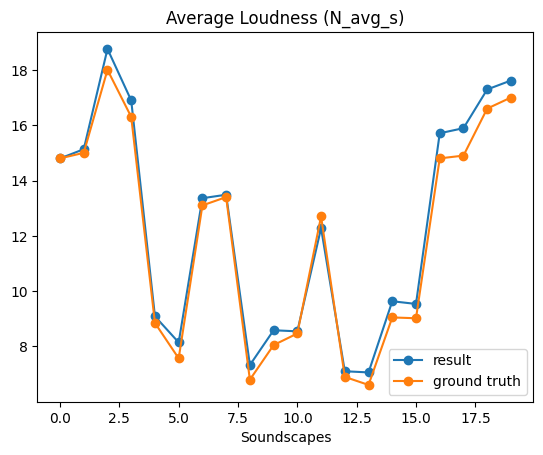

In [74]:
# Average loudness
plt.figure()
plt.plot(N_avg, "o-", label="result")
plt.plot(ground_truth[:,1], "o-", label="ground truth")
#plt.plot(N_avg_r, "o-", label="result_R")
#plt.plot(N_avg_l, "o-", label="result_L")
plt.xlabel('Soundscapes')
plt.title("Average Loudness (N_avg_s)")
plt.legend()
plt.show()

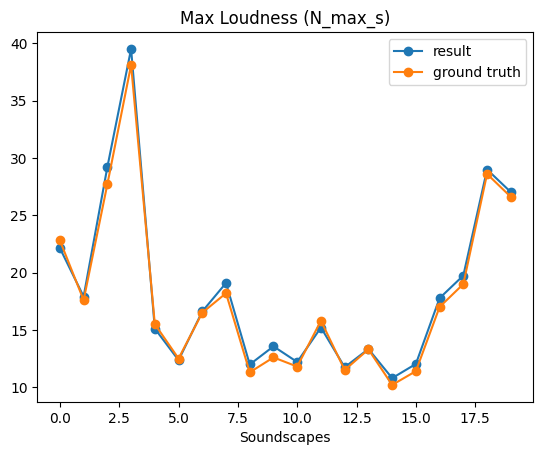

In [76]:
# Maximum loudness
plt.figure()
plt.plot(N_max, "o-", label="result")
plt.plot(ground_truth[:,2], "o-", label="ground truth")
#plt.plot(N_max_r, "o-", label="result_R")
#plt.plot(N_max_l, "o-", label="result_L")
plt.xlabel('Soundscapes')
plt.title("Max Loudness (N_max_s)")
plt.legend()
plt.show()

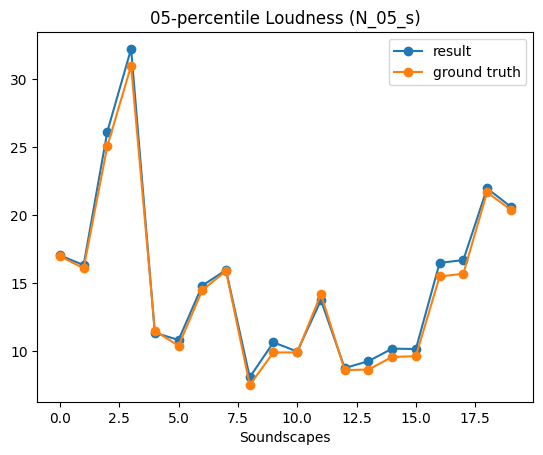

In [75]:
# 05-Percentile loudness
plt.figure()
plt.plot(N_05, "o-", label="result")
plt.plot(ground_truth[:,3], "o-", label="ground truth")
#plt.plot(N_05_r, "o-", label="result_R")
#plt.plot(N_05_l, "o-", label="result_L")
plt.xlabel('Soundscapes')
plt.title("05-percentile Loudness (N_05_s)")
plt.legend()
plt.show()

# Run iteration to find most appropiate gain that results in correct values



In [42]:
def cost_function(current_Navg, current_Nmax, current_N05, desired_Navg, desired_Nmax, desired_N05):
    cost=( np.abs(np.abs(desired_Navg)-np.abs(current_Navg))
        +np.abs(np.abs(desired_Nmax)-np.abs(current_Nmax))
        +np.abs(np.abs(desired_N05)-np.abs(current_N05)))
    return cost

cost=100
gain=4.5
N_avg_true=ground_truth[0,1]
N_max_true=ground_truth[0,2]
N_05_true=ground_truth[0,3]
iteration=0
while cost>0.1 and iteration<10:
    print(iteration)
    # LOAD R0001_segment_binaural_44100_1.wav
    path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
    sigL_test, fs = load(path, wav_calib=gain, ch=0) #L
    sigR_test, fs = load(path, wav_calib=gain, ch=1) #R

    # Calculate loudness
    #L
    N_l_test, N_spec_l_test, bark_axis_l_test, time_axis_l_test = loudness_zwtv(sigL_test, fs, field_type="free")
    N_avg_l_test=np.mean(N_l_test)
    N_max_l_test=np.max(N_l_test)
    N_05_l_test=np.percentile(N_l_test,95)
    print("loudness L calculated")
    #R
    N_r_test, N_spec_r_test, bark_axis_r_test, time_axis_r_test = loudness_zwtv(sigR_test, fs, field_type="free")
    N_avg_r_test=np.mean(N_r_test)
    N_max_r_test=np.max(N_r_test)
    N_05_r_test=np.percentile(N_r_test,95)
    print("loudness R calculated")

    N_avg_test=(N_avg_r_test+ N_avg_l_test)/2
    N_max_test=(N_max_r_test+ N_max_l_test)/2
    N_05_test=(N_05_r_test+N_05_l_test)/2

    cost=cost_function(N_avg_test, N_max_test, N_05_test, N_avg_true, N_max_true, N_05_true)
    
    print("Current Error ", cost)
    iteration=iteration+1
    gain=gain+0.1

print("Found! Gain is ", gain, " with error ", cost)


0
loudness L calculated
loudness R calculated
Current Error  1.2845083045811805
1
loudness L calculated
loudness R calculated
Current Error  0.7312674919934405
2
loudness L calculated
loudness R calculated
Current Error  0.8576058079887865
3


KeyboardInterrupt: 

In [44]:
# Apparently, gain=4.6 gives the best results, lets check with more values

N_avg_true=ground_truth[0,1]
N_max_true=ground_truth[0,2]
N_05_true=ground_truth[0,3]
N_10_true=ground_truth[0,4]
N_20_true=ground_truth[0,5]
N_30_true=ground_truth[0,6]
N_40_true=ground_truth[0,7]
N_50_true=ground_truth[0,8]
N_60_true=ground_truth[0,9]
N_70_true=ground_truth[0,10]
N_80_true=ground_truth[0,11]
N_90_true=ground_truth[0,12]
N_95_true=ground_truth[0,13]

# LOAD R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_test, fs = load(path, wav_calib=4.6, ch=1) #R

# Calculate loudness
#L
N_l_test, N_spec_l_test, bark_axis_l_test, time_axis_l_test = loudness_zwtv(sigL_test, fs, field_type="free")
N_avg_l_test=np.mean(N_l_test)
N_max_l_test=np.max(N_l_test)
N_05_l_test=np.percentile(N_l_test,95)
N_10_l_test=np.percentile(N_l_test,90)
N_20_l_test=np.percentile(N_l_test,80)
N_30_l_test=np.percentile(N_l_test,70)
N_40_l_test=np.percentile(N_l_test,60)
N_50_l_test=np.percentile(N_l_test,50)
N_60_l_test=np.percentile(N_l_test,40)
N_70_l_test=np.percentile(N_l_test,30)
N_80_l_test=np.percentile(N_l_test,20)
N_90_l_test=np.percentile(N_l_test,10)
N_95_l_test=np.percentile(N_l_test,5)
print("loudness L calculated")
#R
N_r_test, N_spec_r_test, bark_axis_r_test, time_axis_r_test = loudness_zwtv(sigR_test, fs, field_type="free")
N_avg_r_test=np.mean(N_r_test)
N_max_r_test=np.max(N_r_test)
N_05_r_test=np.percentile(N_r_test,95)
N_10_r_test=np.percentile(N_r_test,90)
N_20_r_test=np.percentile(N_r_test,80)
N_30_r_test=np.percentile(N_r_test,70)
N_40_r_test=np.percentile(N_r_test,60)
N_50_r_test=np.percentile(N_r_test,50)
N_60_r_test=np.percentile(N_r_test,40)
N_70_r_test=np.percentile(N_r_test,30)
N_80_r_test=np.percentile(N_r_test,20)
N_90_r_test=np.percentile(N_r_test,10)
N_95_r_test=np.percentile(N_r_test,5)
print("loudness R calculated")

N_avg_test=(N_avg_r_test+ N_avg_l_test)/2
N_max_test=(N_max_r_test+ N_max_l_test)/2
N_05_test=(N_05_r_test+N_05_l_test)/2
N_10_test=(N_10_r_test+N_10_l_test)/2
N_20_test=(N_20_r_test+N_20_l_test)/2
N_30_test=(N_30_r_test+N_30_l_test)/2
N_40_test=(N_40_r_test+N_40_l_test)/2
N_50_test=(N_50_r_test+N_50_l_test)/2
N_60_test=(N_60_r_test+N_60_l_test)/2
N_70_test=(N_70_r_test+N_70_l_test)/2
N_80_test=(N_80_r_test+N_80_l_test)/2
N_90_test=(N_90_r_test+N_90_l_test)/2
N_95_test=(N_95_r_test+N_95_l_test)/2

print("Navg, ground truth ",N_avg_true ," and result ",N_avg_test )
print("Nmax, ground truth ",N_max_true ," and result ", N_max_test)
print("N05, ground truth ",N_05_true ," and result ",N_05_test )
print("N10, ground truth ",N_10_true ," and result ",N_10_test )
print("N20, ground truth ",N_20_true ," and result ",N_20_test )
print("N30, ground truth ",N_30_true ," and result ",N_30_test )
print("N40, ground truth ",N_40_true ," and result ",N_40_test )
print("N50, ground truth ",N_50_true ," and result ",N_50_test )
print("N60, ground truth ",N_60_true ," and result ",N_60_test )
print("N70, ground truth ",N_70_true ," and result ",N_70_test )
print("N80, ground truth ",N_80_true ," and result ",N_80_test )
print("N90, ground truth ",N_90_true ," and result ",N_90_test )
print("N95, ground truth ",N_95_true ," and result ",N_95_test )

loudness L calculated
loudness R calculated
Navg, ground truth  14.8  and result  14.7977869361544
Nmax, ground truth  22.8  and result  22.128871550623497
N05, ground truth  17.0  and result  17.057925978771337
N10, ground truth  15.8  and result  15.943368095887774
N20, ground truth  15.2  and result  15.3120614326792
N30, ground truth  14.9  and result  14.98245556818376
N40, ground truth  14.7  and result  14.74071345138461
N50, ground truth  14.5  and result  14.537622821593898
N60, ground truth  14.3  and result  14.363076055725461
N70, ground truth  14.2  and result  14.184954787884982
N80, ground truth  14.0  and result  13.99513005425029
N90, ground truth  13.8  and result  13.762757479823184
N95, ground truth  13.6  and result  13.580102154273641


In [46]:
#Theoretically, both segments of the same audio should have the same gain  and therefore, give good results too
N_avg_true=ground_truth[1,1]
N_max_true=ground_truth[1,2]
N_05_true=ground_truth[1,3]
# LOAD R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_2.wav"
sigL_test, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_test, fs = load(path, wav_calib=4.6, ch=1) #R

# Calculate loudness
#L
N_l_test, N_spec_l_test, bark_axis_l_test, time_axis_l_test = loudness_zwtv(sigL_test, fs, field_type="free")
N_avg_l_test=np.mean(N_l_test)
N_max_l_test=np.max(N_l_test)
N_05_l_test=np.percentile(N_l_test,95)
print("loudness L calculated")
#R
N_r_test, N_spec_r_test, bark_axis_r_test, time_axis_r_test = loudness_zwtv(sigR_test, fs, field_type="free")
N_avg_r_test=np.mean(N_r_test)
N_max_r_test=np.max(N_r_test)
N_05_r_test=np.percentile(N_r_test,95)
print("loudness R calculated")

N_avg_test=(N_avg_r_test+ N_avg_l_test)/2
N_max_test=(N_max_r_test+ N_max_l_test)/2
N_05_test=(N_05_r_test+N_05_l_test)/2

print("Navg, ground truth ",N_avg_true ," and result ",N_avg_test )
print("Nmax, ground truth ",N_max_true ," and result ", N_max_test)
print("N05, ground truth ",N_05_true ," and result ",N_05_test )

loudness L calculated
loudness R calculated
Navg, ground truth  15.0  and result  15.131545576394764
Nmax, ground truth  17.6  and result  17.907771274428278
N05, ground truth  16.1  and result  16.333030362436972


In [49]:
# Also, the same gain is needed to calculate the rest of the psychoacoustic parametres, lets check if the resulting sharpness values are also acceptable with gain=4.6

S_avg_true=1.82
S_max_true=1.99
S_05_true=1.9

# LOAD R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_test, fs = load(path, wav_calib=4.6, ch=1) #R

# Calculate sharpness
#L
S_l_test, S_time_l_test= sharpness_din_tv(sigL_test, fs, field_type="free", skip=0)
S_avg_l_test=np.mean(S_l_test)
S_max_l_test=np.max(S_l_test)
S_05_l_test=np.percentile(S_l_test,95)
#R
S_r_test,S_time_r_test = sharpness_din_tv(sigR_test, fs, field_type="free", skip=0)
S_avg_r_test=np.mean(S_r_test)
S_max_r_test=np.max(S_r_test)
S_05_r_test=np.percentile(S_r_test,95)

S_avg_test=(S_avg_r_test+ S_avg_l_test)/2
S_max_test=(S_max_r_test+ S_max_l_test)/2
S_05_test=(S_05_r_test+S_05_l_test)/2

print("S_avg, ground truth ",S_avg_true ," and result ",S_avg_test )
print("Smax, ground truth ",S_max_true ," and result ", S_max_test)
print("S05, ground truth ",S_05_true ," and result ",S_05_test )

#Results are not great, maybe because of the transient effect that appears on the first points?

[Warning] when computing sharpness from time-varying loudness, a transient effect appears on the first points. To cut it, use 'skip='
[Warning] when computing sharpness from time-varying loudness, a transient effect appears on the first points. To cut it, use 'skip='
S_avg, ground truth  1.82  and result  1.7388053518704614
Smax, ground truth  1.99  and result  21.266443512403235
S05, ground truth  1.9  and result  1.947689646736


In [55]:
R_avg_true=0.0234
R_max_true=0.0684
R_05_true=34

# LOAD R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_test, fs = load(path, wav_calib=4.6, ch=1) #R

# Calculate sharpness
#L
R_l_test, R_spec_l_test, _, _= roughness_dw(sigL_test, fs, 0)
R_avg_l_test=np.mean(R_l_test)
R_max_l_test=np.max(R_l_test)
R_05_l_test=np.percentile(R_l_test,95)
#R
R_r_test,R_spec_r_test,_,_ = roughness_dw(sigR_test, fs, 0)
R_avg_r_test=np.mean(R_r_test)
R_max_r_test=np.max(R_r_test)
R_05_r_test=np.percentile(R_r_test,95)

R_avg_test=(R_avg_r_test+ R_avg_l_test)/2
R_max_test=(R_max_r_test+ R_max_l_test)/2
R_05_test=(R_05_r_test+R_05_l_test)/2

print("R_avg, ground truth ",R_avg_true ," and result ",R_avg_test )
print("Rmax, ground truth ",R_max_true ," and result ", R_max_test)
print("R05, ground truth ",R_05_true ," and result ",R_05_test )

# NOT THE CORRECT FORMULA


R_avg, ground truth  0.0234  and result  0.04967090882072075
Rmax, ground truth  0.0684  and result  0.1771842365234356
R05, ground truth  34  and result  0.0977160795348132


In [64]:
# lets try with tonality

T_avg_true=0.0592
T_max_true=1.04
T_05_true=0.29

# LOAD R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_test, fs = load(path, wav_calib=4.6, ch=1) #R

# Calculate sharpness
#L
tT_l_test, T_l_test, _, _,_= tnr_ecma_tv(sigL_test, fs,prominence=True, overlap=0)
print(" L ",T_l_test, tT_l_test)
T_avg_l_test=np.mean(T_l_test)
T_max_l_test=np.max(T_l_test)
T_05_l_test=np.percentile(T_l_test,95)
#R
_, T_r_test, _, _,_= tnr_ecma_tv(sigR_test, fs,prominence=True, overlap=0)
print(" R ",T_r_test )
T_avg_r_test=np.mean(T_r_test)
T_max_r_test=np.max(T_r_test)
T_05_r_test=np.percentile(T_r_test,95)

T_avg_test=(T_avg_r_test+ T_avg_l_test)/2
T_max_test=(T_max_r_test+ T_max_l_test)/2
T_05_test=(T_05_r_test+T_05_l_test)/2

print("T_avg, ground truth ",T_avg_true ," and result ",T_avg_test )
print("Tmax, ground truth ",T_max_true ," and result ", T_max_test)
print("T05, ground truth ",T_05_true ," and result ",T_05_test )

 L  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 R  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
T_avg, ground truth  0.0592  and result  nan
Tmax, ground truth  1.04  and result  nan
T05, ground truth  0.29  and result  nan


### repeat process above to generate  graphs with correct 4.6 gain

In [59]:

# R0001_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_1.wav"
sigL_0001_1, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0001_1, fs = load(path, wav_calib=4.6, ch=1) #R

# R0001_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0001_segment_binaural_44100_2.wav"
sigL_0001_2, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0001_2, fs = load(path, wav_calib=4.6, ch=1) #R

# R0002_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0002_segment_binaural_44100_1.wav"
sigL_0002_1, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0002_1, fs = load(path, wav_calib=4.6, ch=1) #R

# R0002_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0002_segment_binaural_44100_2.wav"
sigL_0002_2, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0002_2, fs = load(path, wav_calib=4.6, ch=1) #R

# R0003_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0003_segment_binaural_44100_1.wav"
sigL_0003_1, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0003_1, fs = load(path, wav_calib=4.6, ch=1) #R

# R0003_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0003_segment_binaural_44100_2.wav"
sigL_0003_2, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0003_2, fs = load(path, wav_calib=4.6, ch=1) #R

# R0004_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0004_segment_binaural_44100_1.wav"
sigL_0004_1, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0004_1, fs = load(path, wav_calib=4.6, ch=1) #R

# R0004_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0004_segment_binaural_44100_2.wav"
sigL_0004_2, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0004_2, fs = load(path, wav_calib=4.6, ch=1) #R

# R0005_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0005_segment_binaural_44100_1.wav"
sigL_0005_1, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0005_1, fs = load(path, wav_calib=4.6, ch=1) #R

# R0005_segment_binaural_44100_2.wav
path = "../data/soundscapes/R0005_segment_binaural_44100_2.wav"
sigL_0005_2, fs = load(path, wav_calib=4.6, ch=0) #L
sigR_0005_2, fs = load(path, wav_calib=4.6, ch=1) #R

###########

# R0001_segment_binaural_44100_1.wav
#L
N_l_0001_1, N_spec_l_0001_1, bark_axis_l_0001_1, time_axis_l_0001_1 = loudness_zwtv(sigL_0001_1, fs, field_type="free")
N_avg_l_0001_1=np.mean(N_l_0001_1)
N_max_l_0001_1=np.max(N_l_0001_1)
N_05_l_0001_1=np.percentile(N_l_0001_1,95)
#R
N_r_0001_1, N_spec_r_0001_1, bark_axis_r_0001_1, time_axis_r_0001_1 = loudness_zwtv(sigR_0001_1, fs, field_type="free")
N_avg_r_0001_1=np.mean(N_r_0001_1)
N_max_r_0001_1=np.max(N_r_0001_1)
N_05_r_0001_1=np.percentile(N_r_0001_1,95)

# R0001_segment_binaural_44100_2.wav
#L
N_l_0001_2, N_spec_l_0001_2, bark_axis_l_0001_2, time_axis_l_0001_2 = loudness_zwtv(sigL_0001_2, fs, field_type="free")
N_avg_l_0001_2=np.mean(N_l_0001_2)
N_max_l_0001_2=np.max(N_l_0001_2)
N_05_l_0001_2=np.percentile(N_l_0001_2,95)
#R
N_r_0001_2, N_spec_r_0001_2, bark_axis_r_0001_2, time_axis_r_0001_2 = loudness_zwtv(sigR_0001_2, fs, field_type="free")
N_avg_r_0001_2=np.mean(N_r_0001_2)
N_max_r_0001_2=np.max(N_r_0001_2)
N_05_r_0001_2=np.percentile(N_r_0001_2,95)

# R0002_segment_binaural_44100_1.wav
#L
N_l_0002_1, N_spec_l_0002_1, bark_axis_l_0002_1, time_axis_l_0002_1 = loudness_zwtv(sigL_0002_1, fs, field_type="free")
N_avg_l_0002_1=np.mean(N_l_0002_1)
N_max_l_0002_1=np.max(N_l_0002_1)
N_05_l_0002_1=np.percentile(N_l_0002_1,95)
#R
N_r_0002_1, N_spec_r_0002_1, bark_axis_r_0002_1, time_axis_r_0002_1 = loudness_zwtv(sigR_0002_1, fs, field_type="free")
N_avg_r_0002_1=np.mean(N_r_0002_1)
N_max_r_0002_1=np.max(N_r_0002_1)
N_05_r_0002_1=np.percentile(N_r_0002_1,95)

# R0002_segment_binaural_44100_2.wav
#L
N_l_0002_2, N_spec_l_0002_2, bark_axis_l_0002_2, time_axis_l_0002_2 = loudness_zwtv(sigL_0002_2, fs, field_type="free")
N_avg_l_0002_2=np.mean(N_l_0002_2)
N_max_l_0002_2=np.max(N_l_0002_2)
N_05_l_0002_2=np.percentile(N_l_0002_2,95)
#R
N_r_0002_2, N_spec_r_0002_2, bark_axis_r_0002_2, time_axis_r_0002_2 = loudness_zwtv(sigR_0002_2, fs, field_type="free")
N_avg_r_0002_2=np.mean(N_r_0002_2)
N_max_r_0002_2=np.max(N_r_0002_2)
N_05_r_0002_2=np.percentile(N_r_0002_2,95)

# R0003_segment_binaural_44100_1.wav
#L
N_l_0003_1, N_spec_l_0003_1, bark_axis_l_0003_1, time_axis_l_0003_1 = loudness_zwtv(sigL_0003_1, fs, field_type="free")
N_avg_l_0003_1=np.mean(N_l_0003_1)
N_max_l_0003_1=np.max(N_l_0003_1)
N_05_l_0003_1=np.percentile(N_l_0003_1,95)
#R
N_r_0003_1, N_spec_r_0003_1, bark_axis_r_0003_1, time_axis_r_0003_1 = loudness_zwtv(sigR_0003_1, fs, field_type="free")
N_avg_r_0003_1=np.mean(N_r_0003_1)
N_max_r_0003_1=np.max(N_r_0003_1)
N_05_r_0003_1=np.percentile(N_r_0003_1,95)

# R0003_segment_binaural_44100_2.wav
#L
N_l_0003_2, N_spec_l_0003_2, bark_axis_l_0003_2, time_axis_l_0003_2 = loudness_zwtv(sigL_0003_2, fs, field_type="free")
N_avg_l_0003_2=np.mean(N_l_0003_2)
N_max_l_0003_2=np.max(N_l_0003_2)
N_05_l_0003_2=np.percentile(N_l_0003_2,95)
#R
N_r_0003_2, N_spec_r_0003_2, bark_axis_r_0003_2, time_axis_r_0003_2 = loudness_zwtv(sigR_0003_2, fs, field_type="free")
N_avg_r_0003_2=np.mean(N_r_0003_2)
N_max_r_0003_2=np.max(N_r_0003_2)
N_05_r_0003_2=np.percentile(N_r_0003_2,95)

# R0004_segment_binaural_44100_1.wav
#L
N_l_0004_1, N_spec_l_0004_1, bark_axis_l_0004_1, time_axis_l_0004_1 = loudness_zwtv(sigL_0004_1, fs, field_type="free")
N_avg_l_0004_1=np.mean(N_l_0004_1)
N_max_l_0004_1=np.max(N_l_0004_1)
N_05_l_0004_1=np.percentile(N_l_0004_1,95)
#R
N_r_0004_1, N_spec_r_0004_1, bark_axis_r_0004_1, time_axis_r_0004_1 = loudness_zwtv(sigR_0004_1, fs, field_type="free")
N_avg_r_0004_1=np.mean(N_r_0004_1)
N_max_r_0004_1=np.max(N_r_0004_1)
N_05_r_0004_1=np.percentile(N_r_0004_1,95)

# R0004_segment_binaural_44100_2.wav
#L
N_l_0004_2, N_spec_l_0004_2, bark_axis_l_0004_2, time_axis_l_0004_2 = loudness_zwtv(sigL_0004_2, fs, field_type="free")
N_avg_l_0004_2=np.mean(N_l_0004_2)
N_max_l_0004_2=np.max(N_l_0004_2)
N_05_l_0004_2=np.percentile(N_l_0004_2,95)
#R
N_r_0004_2, N_spec_r_0004_2, bark_axis_r_0004_2, time_axis_r_0004_2 = loudness_zwtv(sigR_0004_2, fs, field_type="free")
N_avg_r_0004_2=np.mean(N_r_0004_2)
N_max_r_0004_2=np.max(N_r_0004_2)
N_05_r_0004_2=np.percentile(N_r_0004_2,95)

# R0005_segment_binaural_44100_1.wav
#L
N_l_0005_1, N_spec_l_0005_1, bark_axis_l_0005_1, time_axis_l_0005_1 = loudness_zwtv(sigL_0005_1, fs, field_type="free")
N_avg_l_0005_1=np.mean(N_l_0005_1)
N_max_l_0005_1=np.max(N_l_0005_1)
N_05_l_0005_1=np.percentile(N_l_0005_1,95)
#R
N_r_0005_1, N_spec_r_0005_1, bark_axis_r_0005_1, time_axis_r_0005_1 = loudness_zwtv(sigR_0005_1, fs, field_type="free")
N_avg_r_0005_1=np.mean(N_r_0005_1)
N_max_r_0005_1=np.max(N_r_0005_1)
N_05_r_0005_1=np.percentile(N_r_0005_1,95)

# R0005_segment_binaural_44100_2.wav
#L
N_l_0005_2, N_spec_l_0005_2, bark_axis_l_0005_2, time_axis_l_0005_2 = loudness_zwtv(sigL_0005_2, fs, field_type="free")
N_avg_l_0005_2=np.mean(N_l_0005_2)
N_max_l_0005_2=np.max(N_l_0005_2)
N_05_l_0005_2=np.percentile(N_l_0005_2,95)
#R
N_r_0005_2, N_spec_r_0005_2, bark_axis_r_0005_2, time_axis_r_0005_2 = loudness_zwtv(sigR_0005_2, fs, field_type="free")
N_avg_r_0005_2=np.mean(N_r_0005_2)
N_max_r_0005_2=np.max(N_r_0005_2)
N_05_r_0005_2=np.percentile(N_r_0005_2,95)

############
N_avg_l=np.array([N_avg_l_0001_1,N_avg_l_0001_2
                  ,N_avg_l_0002_1, N_avg_l_0002_2,
                  N_avg_l_0003_1, N_avg_l_0003_2,
                  N_avg_l_0004_1, N_avg_l_0004_2,
                  N_avg_l_0005_1, N_avg_l_0005_2,
                  ])

N_avg_r=np.array([N_avg_r_0001_1,N_avg_r_0001_2
                  ,N_avg_r_0002_1, N_avg_r_0002_2,
                  N_avg_r_0003_1, N_avg_r_0003_2,
                  N_avg_r_0004_1, N_avg_r_0004_2,
                  N_avg_r_0005_1, N_avg_r_0005_2,
                  ])

N_max_l=np.array([ N_max_l_0001_1, N_max_l_0001_2,
                  N_max_l_0002_1, N_max_l_0002_2,
                  N_max_l_0003_1, N_max_l_0003_2,
                  N_max_l_0004_1, N_max_l_0004_2,
                  N_max_l_0005_1, N_max_l_0005_2,
                ])
N_max_r=np.array([ N_max_r_0001_1, N_max_r_0001_2,
                  N_max_r_0002_1, N_max_r_0002_2,
                  N_max_r_0003_1, N_max_r_0003_2,
                  N_max_r_0004_1, N_max_r_0004_2,
                  N_max_r_0005_1, N_max_r_0005_2,
                ])

N_05_l=np.array([
    N_05_l_0001_1, N_05_l_0001_2,
    N_05_l_0002_1, N_05_l_0002_2,
    N_05_l_0003_1, N_05_l_0003_2,
    N_05_l_0004_1, N_05_l_0004_2,
    N_05_l_0005_1, N_05_l_0005_2,
])

N_05_r=np.array([
    N_05_r_0001_1, N_05_r_0001_2,
    N_05_r_0002_1, N_05_r_0002_2,
    N_05_r_0003_1, N_05_r_0003_2,
    N_05_r_0004_1, N_05_r_0004_2,
    N_05_r_0005_1, N_05_r_0005_2,
])

N_avg=(N_avg_l+N_avg_r)/2
N_max=(N_max_l+N_max_r)/2
N_05=(N_05_l+N_05_r)/2


############



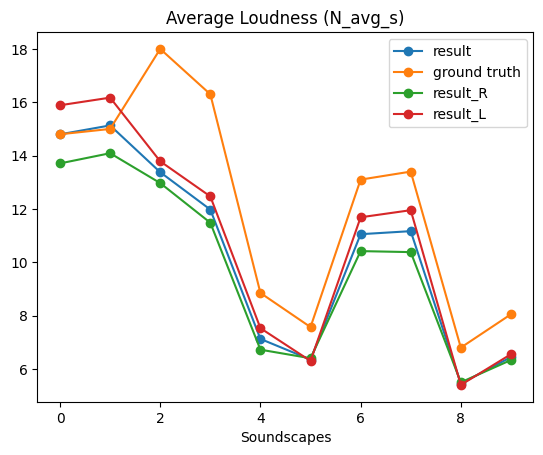

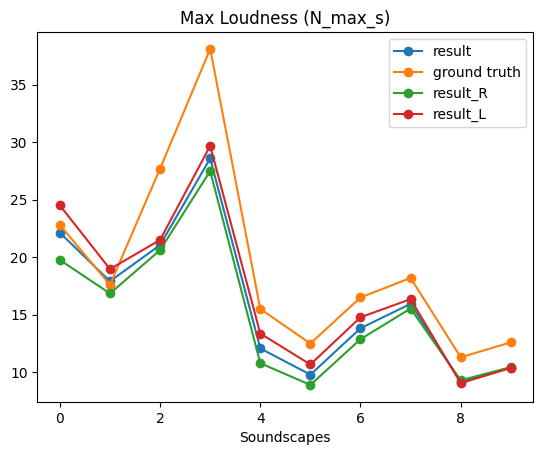

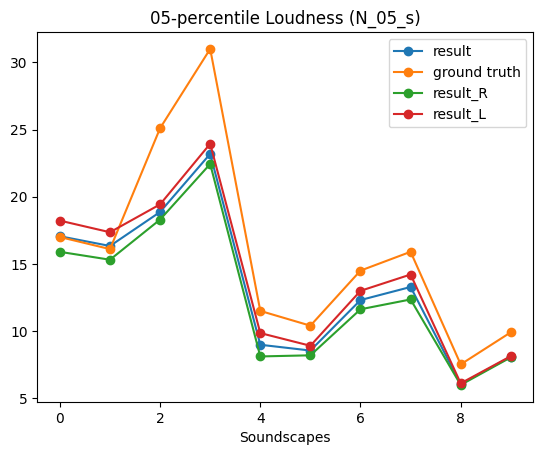

In [62]:
# Average loudness
plt.figure()
plt.plot(N_avg, "o-", label="result")
plt.plot(ground_truth[0:10,1], "o-", label="ground truth")
plt.plot(N_avg_r, "o-", label="result_R")
plt.plot(N_avg_l, "o-", label="result_L")
plt.xlabel('Soundscapes')
plt.title("Average Loudness (N_avg_s)")
plt.legend()
plt.show()

# Maximum loudness
plt.figure()
plt.plot(N_max, "o-", label="result")
plt.plot(ground_truth[0:10:,2], "o-", label="ground truth")
plt.plot(N_max_r, "o-", label="result_R")
plt.plot(N_max_l, "o-", label="result_L")
plt.xlabel('Soundscapes')
plt.title("Max Loudness (N_max_s)")
plt.legend()
plt.show()

# 05-Percentile loudness
plt.figure()
plt.plot(N_05, "o-", label="result")
plt.plot(ground_truth[0:10,3], "o-", label="ground truth")
plt.plot(N_05_r, "o-", label="result_R")
plt.plot(N_05_l, "o-", label="result_L")
plt.xlabel('Soundscapes')
plt.title("05-percentile Loudness (N_05_s)")
plt.legend()
plt.show()

In [65]:
# Trying proportional gain calculation

gain0002=4.6*1.363361/0.759272

N_avg_true=ground_truth[2,1]
N_max_true=ground_truth[2,2]
N_05_true=ground_truth[2,3]
# LOAD R0002_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0002_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=gain0002, ch=0) #L
sigR_test, fs = load(path, wav_calib=gain0002, ch=1) #R

# Calculate loudness
#L
N_l_test, N_spec_l_test, bark_axis_l_test, time_axis_l_test = loudness_zwtv(sigL_test, fs, field_type="free")
N_avg_l_test=np.mean(N_l_test)
N_max_l_test=np.max(N_l_test)
N_05_l_test=np.percentile(N_l_test,95)
print("loudness L calculated")
#R
N_r_test, N_spec_r_test, bark_axis_r_test, time_axis_r_test = loudness_zwtv(sigR_test, fs, field_type="free")
N_avg_r_test=np.mean(N_r_test)
N_max_r_test=np.max(N_r_test)
N_05_r_test=np.percentile(N_r_test,95)
print("loudness R calculated")

N_avg_test=(N_avg_r_test+ N_avg_l_test)/2
N_max_test=(N_max_r_test+ N_max_l_test)/2
N_05_test=(N_05_r_test+N_05_l_test)/2

print("Navg, ground truth ",N_avg_true ," and result ",N_avg_test )
print("Nmax, ground truth ",N_max_true ," and result ", N_max_test)
print("N05, ground truth ",N_05_true ," and result ",N_05_test )





loudness L calculated
loudness R calculated
Navg, ground truth  18.0  and result  18.75684253181157
Nmax, ground truth  27.7  and result  29.201048637935628
N05, ground truth  25.1  and result  26.16581599607364


In [66]:
gain0003=4.6*1.114716/0.759272

N_avg_true=ground_truth[4,1]
N_max_true=ground_truth[4,2]
N_05_true=ground_truth[4,3]
# LOAD R0002_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0003_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=gain0002, ch=0) #L
sigR_test, fs = load(path, wav_calib=gain0002, ch=1) #R

# Calculate loudness
#L
N_l_test, N_spec_l_test, bark_axis_l_test, time_axis_l_test = loudness_zwtv(sigL_test, fs, field_type="free")
N_avg_l_test=np.mean(N_l_test)
N_max_l_test=np.max(N_l_test)
N_05_l_test=np.percentile(N_l_test,95)
print("loudness L calculated")
#R
N_r_test, N_spec_r_test, bark_axis_r_test, time_axis_r_test = loudness_zwtv(sigR_test, fs, field_type="free")
N_avg_r_test=np.mean(N_r_test)
N_max_r_test=np.max(N_r_test)
N_05_r_test=np.percentile(N_r_test,95)
print("loudness R calculated")

N_avg_test=(N_avg_r_test+ N_avg_l_test)/2
N_max_test=(N_max_r_test+ N_max_l_test)/2
N_05_test=(N_05_r_test+N_05_l_test)/2

print("Navg, ground truth ",N_avg_true ," and result ",N_avg_test )
print("Nmax, ground truth ",N_max_true ," and result ", N_max_test)
print("N05, ground truth ",N_05_true ," and result ",N_05_test )

loudness L calculated
loudness R calculated
Navg, ground truth  8.85  and result  10.288668161717572
Nmax, ground truth  15.5  and result  16.974799599471844
N05, ground truth  11.5  and result  12.804605755698976


In [67]:
gain0003=4.6*1.463234/0.759272

N_avg_true=ground_truth[14,1]
N_max_true=ground_truth[14,2]
N_05_true=ground_truth[14,3]
# LOAD R0002_segment_binaural_44100_1.wav
path = "../data/soundscapes/R0008_segment_binaural_44100_1.wav"
sigL_test, fs = load(path, wav_calib=gain0002, ch=0) #L
sigR_test, fs = load(path, wav_calib=gain0002, ch=1) #R

# Calculate loudness
#L
N_l_test, N_spec_l_test, bark_axis_l_test, time_axis_l_test = loudness_zwtv(sigL_test, fs, field_type="free")
N_avg_l_test=np.mean(N_l_test)
N_max_l_test=np.max(N_l_test)
N_05_l_test=np.percentile(N_l_test,95)
print("loudness L calculated")
#R
N_r_test, N_spec_r_test, bark_axis_r_test, time_axis_r_test = loudness_zwtv(sigR_test, fs, field_type="free")
N_avg_r_test=np.mean(N_r_test)
N_max_r_test=np.max(N_r_test)
N_05_r_test=np.percentile(N_r_test,95)
print("loudness R calculated")

N_avg_test=(N_avg_r_test+ N_avg_l_test)/2
N_max_test=(N_max_r_test+ N_max_l_test)/2
N_05_test=(N_05_r_test+N_05_l_test)/2

print("Navg, ground truth ",N_avg_true ," and result ",N_avg_test )
print("Nmax, ground truth ",N_max_true ," and result ", N_max_test)
print("N05, ground truth ",N_05_true ," and result ",N_05_test )

loudness L calculated
loudness R calculated
Navg, ground truth  9.05  and result  9.221986870078101
Nmax, ground truth  10.2  and result  10.344163560481547
N05, ground truth  9.58  and result  9.757856953759696
